# Analysis of local search behavior after reward in 2-object forest
### Assumes use of FlyOver version 9.7 or higher (closed-loop optogenetic stimulation possible)
### Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [194]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from scipy import stats as sts

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleTwoObjVROptogenTrialAnalysis

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import plotWalkingVelocityDistr
from plottingUtilities.plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df,\
            plotVeloHeadingDistribution2_flyVR_df,oneDimResidencyWithVar_2LM_df
from plottingUtilities.objectPreferencePlots import countvisits, diffCorrPlot, prettyBoxPlot, simpleBoxPlot,\
            landmarksInSquareTile


# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [195]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#my_indices = [2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 29]
#expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = ''#'_min3visitsEachPre'  # chose small string, to specify dataset (e.g. top5 flies)

In [196]:
expDirs=expDirs[:]
print(expDirs)

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30']


In [197]:
%matplotlib inline

### Compose mutli-fly data into dataframe

In [198]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [199]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [200]:
genotype = dataDir.split(sep)[-5]
protocol = dataDir.split(sep)[-3]
print(genotype)
print(protocol)

Gr64f-Double-Gal4_x_10xChrimsonR
control_20min_15mm


In [201]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','protocol','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[6]
        stimT = fileToAnalyse.split('_')[-4]
        
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleTwoObjVROptogenTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
        elif 'pre' in fileToAnalyse:
            trialtype = 'pre'
            rZones = 'off'
        else:
            trialtype = 'post'
            rZones = 'off'
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'protocol', protocol)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/control_20min_15mm/rawData/f01/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_24h_f01_200ms_post_out_180321205418.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_24h_f01_200ms_pre_out_180321202321.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_24h_f01_200ms_train_out_180321203351.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/control_20min_15mm/rawData/f02/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_24h_f02_200ms_post_out_180321215314.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_24h_f02_200ms_pre_o

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/control_20min_15mm/rawData/f15/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_7-8d_24h_f15_200ms_post_out_180328020953.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_7-8d_24h_f15_200ms_pre_out_180328013421.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_7-8d_24h_f15_200ms_train_out_180328014622.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/control_20min_15mm/rawData/f16/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_7-8d_24h_f16_200ms_post_out_180328030153.txt', 'twoObjectForestControl_1cm4cmCo

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/control_20min_15mm/rawData/f29/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_8-9d_24h_f29_200ms_post_out_180405201103.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_8-9d_24h_f29_200ms_pre_out_180405193620.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_8-9d_24h_f29_200ms_train_out_180405194843.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/Gr64f-Double-Gal4_x_10xChrimsonR/female/control_20min_15mm/rawData/f30/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_8-9d_24h_f30_200ms_post_out_180405215006.txt', 'twoObjectForestControl_1cm4cmCo

In [202]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df.head()

flyID trial trialtype reinforcement            protocol  moving  \
0   f01   1.0      post           off  control_20min_15mm     1.0   
1   f01   1.0      post           off  control_20min_15mm     1.0   
2   f01   1.0      post           off  control_20min_15mm     1.0   
3   f01   1.0      post           off  control_20min_15mm     1.0   
4   f01   1.0      post           off  control_20min_15mm     1.0   

   headingAngle   rotVelo      time  transVelo       xPos  xPosInMiniarena  \
0     -0.000004  0.266288  0.000000   2.297353  60.622000        60.622000   
1      0.013312  1.331058  0.050005   2.521497  60.539505        60.539505   
2      0.079871  2.750846  0.100009   4.311905  60.445700        60.445700   
3      0.217426  3.283286  0.150014   4.206017  60.498700        60.498700   
4      0.381606  2.715272  0.200019   8.846801  60.488980        60.488980   

        yPos  yPosInMiniarena  rEvents  
0  35.000000        35.000000      0.0  
1  35.079947        35.079947      0.0  
2  35.164200        35.164200      0.0  
3  35.373200        35.373200      0.0  
4  35.583296        35.583296      0.0

In [203]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df['flyID'].values).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [204]:
# Two object reinforcement test
rZoneState = ['off','on','off']
trialName = ['pre','train','post']
gridSize = 60.0

fps = 20.0 # after downsampling

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'
LMcols = [coneColor,cyliColor]

LMnames = ['Cone','Cylinder']
nLMtypes = len(LMnames)

In [205]:
visitRad = 15
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

LMcoords = [coneCoords, cyliCoords]

LMcoordsShift = [cyliCoords,coneCoords]
LMcoordsCenter = [
    [[gridSize, 0],
    [0, gridSize]],
    [[0, 0],
    [gridSize, gridSize]]]

### Compute visit counts

In [206]:
visitFreq = np.nan*np.ones((nLMtypes, numFlies, len(trialName)))
visitCount = np.nan*np.ones((nLMtypes, numFlies, len(trialName)))
visitLength = np.zeros((nLMtypes, numFlies, len(trialName)))

for fly in range(numFlies):
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (nLMtypes, len(xtrial)) )
        
        for obj in range(nLMtypes):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],time,visitRad)
        
            visitFreq[obj,fly,trial] = np.sum(entries)/(time[-1]/60.0)
            visitCount[obj,fly,trial] = np.sum(entries)
            visitLength[obj,fly,trial] = np.sum(visitT)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in minimum


### Selection of flies for analysis based on landmark visits

In [207]:
# minimum amount of visits to ANY landmark in any trial to be considered in ananlysis
minVisit = 5

notEnoughVisits = np.where(np.sum((visitCount[0][:,:] + visitCount[1][:,:])> minVisit, axis=1)<3)[0]
keepflies = list(np.where(np.sum((visitCount[0][:,:] + visitCount[1][:,:])> minVisit, axis=1)>=3)[0])

# median # visits during training in group of flies that performed minimum amount of visits:
keepMedian = np.median(visitCount[0][keepflies,1])

# split flies to keep along the median
aboveMedian = list(set(np.where(visitCount[0][:,1]>keepMedian)[0]).intersection(set(keepflies)))
belowMedian = list(set(np.where(visitCount[0][:,1]<=keepMedian)[0]).intersection(set(keepflies)))

print('Out of {} measured flies, {} made less than {} landmark visits in at least one of the three trials ({}%).\n').format(numFlies,
     len(notEnoughVisits), minVisit, 100*len(notEnoughVisits)/numFlies)
print('Flies that made enough visits:')
print(keepflies)
print('\n')
print('The remaining {} flies can be split along the median of {} visits:').format(len(keepflies), keepMedian)
print('Above median:')
print(aboveMedian)
print('Below or equal to median:')
print(belowMedian)

Out of 30 measured flies, 12 made less than 5 landmark visits in at least one of the three trials (40%).

Flies that made enough visits:
[0, 1, 2, 4, 5, 6, 8, 10, 12, 13, 14, 15, 16, 18, 21, 22, 25, 26]


The remaining 18 flies can be split along the median of 8.5 visits:
Above median:
[0, 5, 6, 8, 10, 12, 21, 22, 26]
Below or equal to median:
[1, 2, 4, 13, 14, 15, 16, 18, 25]


In [208]:
# minimum amount of visits to EACH landmark in the PRE-trial to be considered in ananlysis
minVisitLM = 3

notEnoughVisits = np.where(((visitCount[0][:,0] > minVisitLM).astype('int') + 
                            (visitCount[1][:,0] > minVisitLM).astype('int')) <2)[0]
keepflies = list(np.where(((visitCount[0][:,0] > minVisitLM).astype('int') + 
                           (visitCount[1][:,0] > minVisitLM).astype('int')) >=2)[0])

print('Flies that made enough visits:')
print(keepflies)
print('n = ' + str(len(keepflies)))

Flies that made enough visits:
[1, 4, 8, 10, 12, 13, 15, 16, 18, 25, 26]
n = 11


### Trajectory plots of all trials shifted (to make sure reward zone is centered in shifted control)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


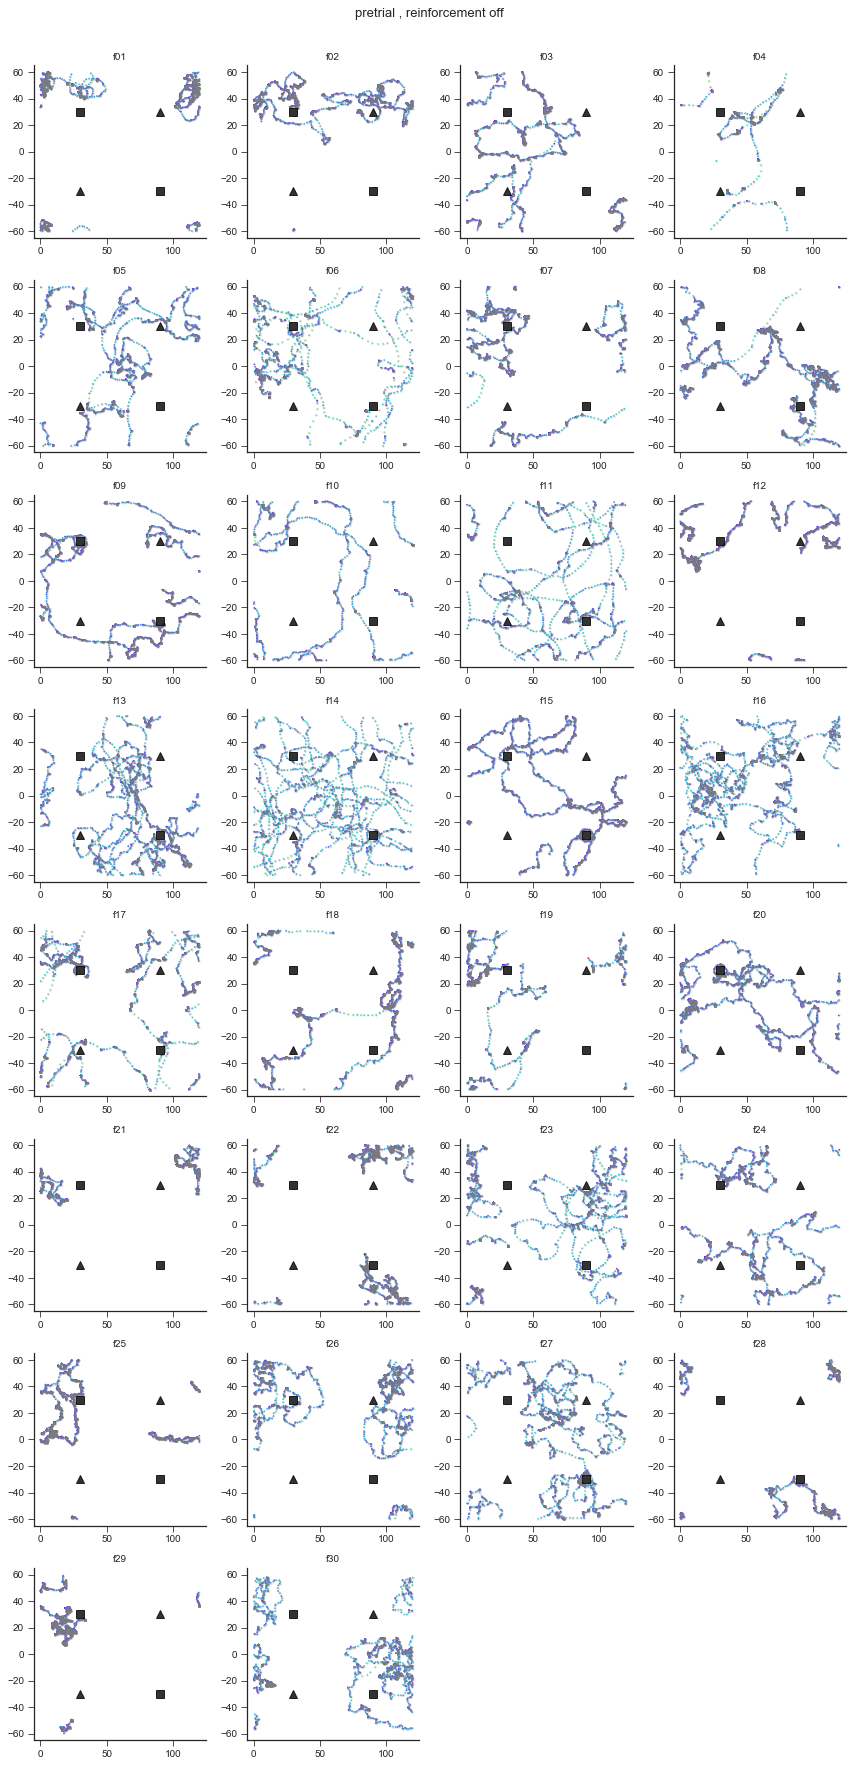

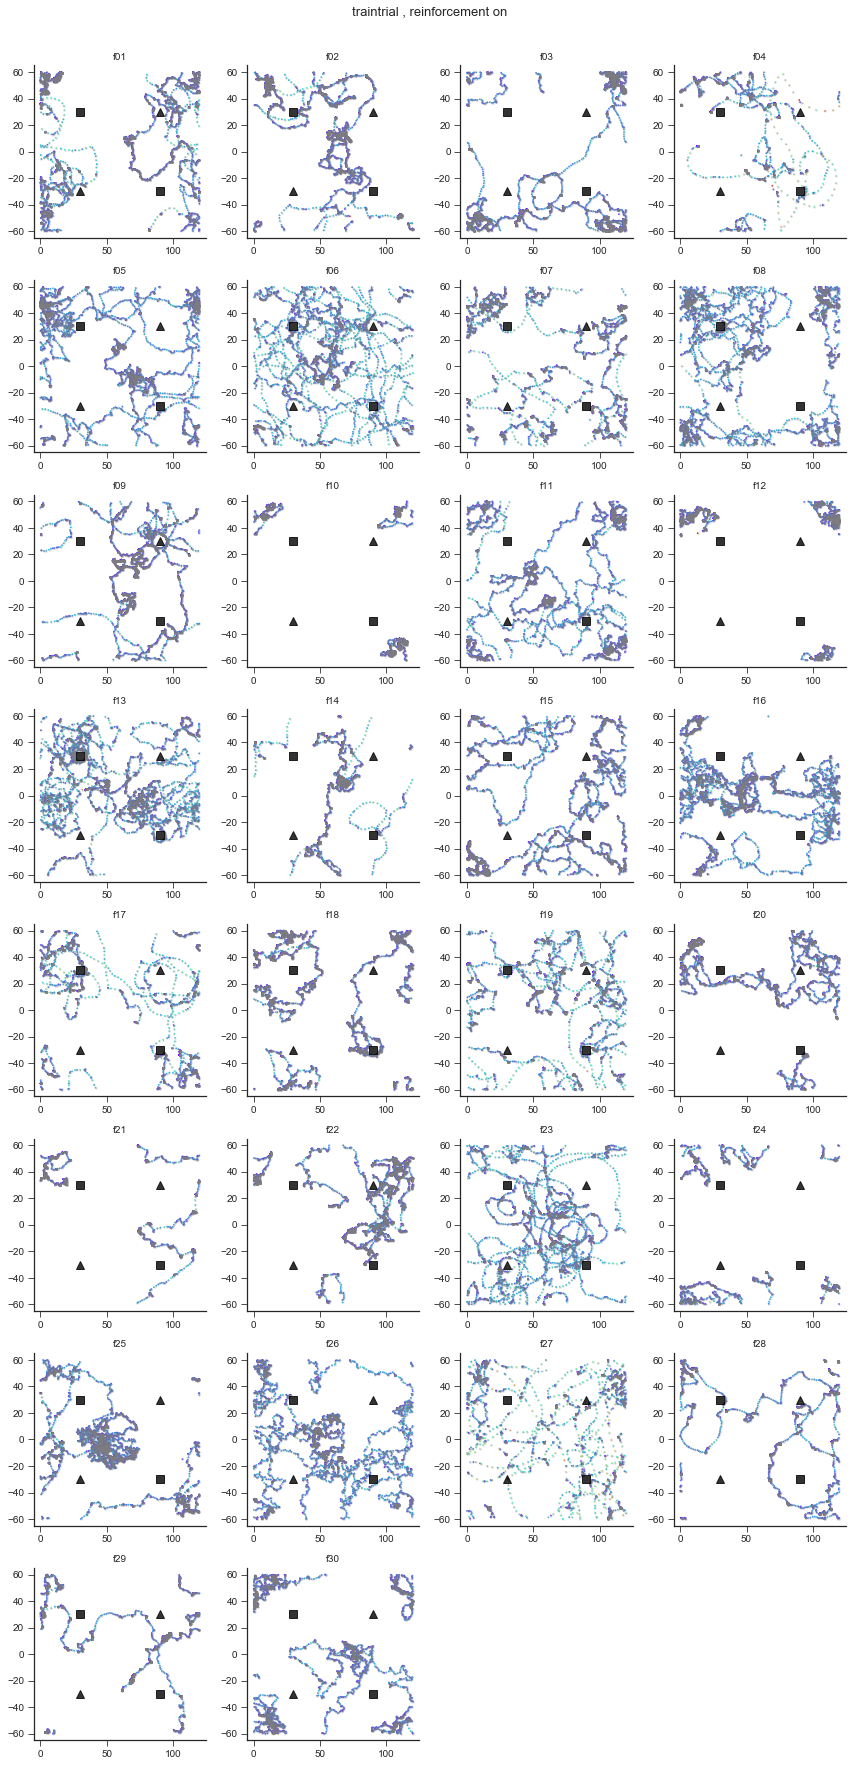

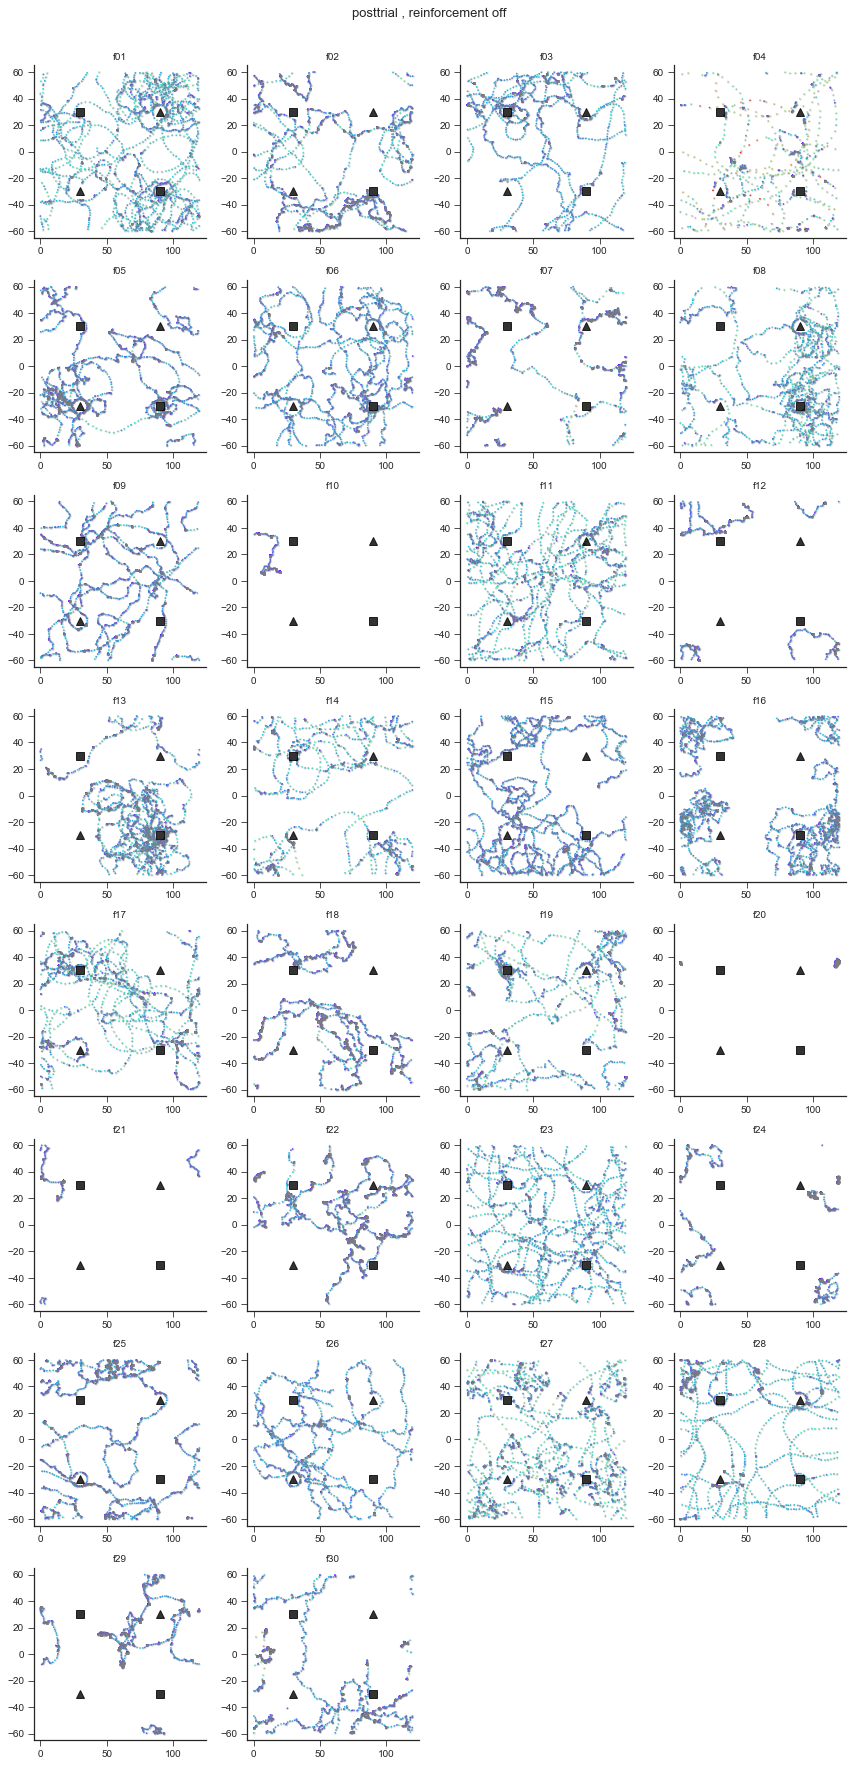

In [209]:
nrows = np.ceil(numFlies/4.0)
ptsOmit = 5 # scale how many time points are plotted

for ttind,trialtype in enumerate(trialName):
    multiflyTracePlot = plt.figure(figsize=(12,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + 'trial , reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        perFlyY = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
        
        #shift along x-axis
        perFlyX = perFlyX+gridSize
        perFlyX[perFlyX>2*gridSize] = perFlyX[perFlyX>2*gridSize]-2*gridSize
        
        selectPts = range(0,len(perFlyX),ptsOmit)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        landmarksInSquareTile(multiflyTracePlot_sbplt, LMcoordsShift, ['k','k'])
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-5, gridSize*2 + 5)
        multiflyTracePlot_sbplt.set_ylim(-5-gridSize, gridSize + 5)
        
    multiflyTracePlot.tight_layout()
    
    multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype
                              +'_shifted-traceVeloColored_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Residency

### 2D (cartesian) residency in shifted space

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


Plot directory already exists


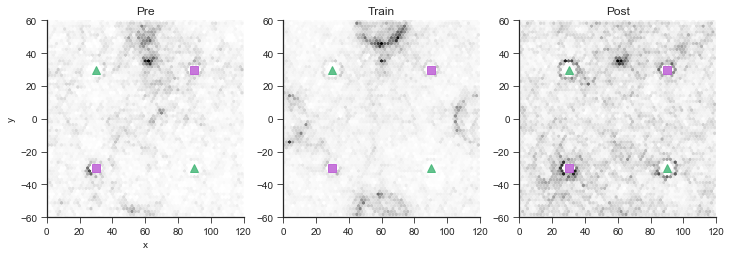

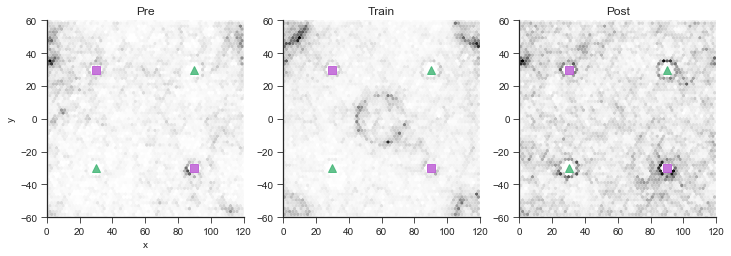

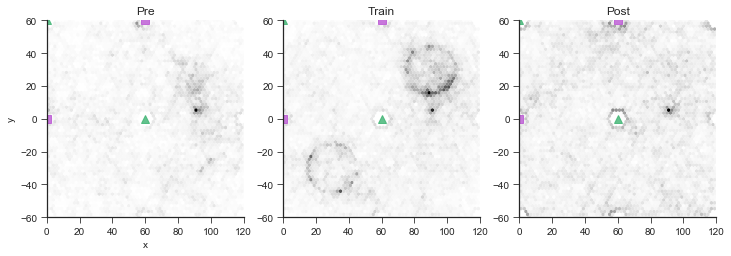

In [210]:
# plot parameter
numBins = 60

hexplotfig = plt.figure(figsize=(12,4))
hexplotfigShift = plt.figure(figsize=(12,4))
hexplotfigCenter = plt.figure(figsize=(12,4))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring)['xPosInMiniarena']).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring)['yPosInMiniarena']).squeeze()
    
    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys',linewidths=0)
    if trial ==0: ax.set_xlabel('x'); ax.set_ylabel('y')
    landmarksInSquareTile(ax, LMcoords, LMcols)
    ax.set_title(trialName[trial].capitalize())
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
    
    #shift along x-axis
    xPosMA = xPosMA+gridSize
    xPosMA[xPosMA>2*gridSize] = xPosMA[xPosMA>2*gridSize]-2*gridSize
        
    ax = hexplotfigShift.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys',linewidths=0)
    if trial ==0: ax.set_xlabel('x'); ax.set_ylabel('y')
    landmarksInSquareTile(ax, LMcoordsShift, LMcols)    
    ax.set_title(trialName[trial].capitalize())
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
    
    #center zone
    xPosMA = np.asarray(FOAllFlies_df.query(querystring)['xPosInMiniarena']).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring)['yPosInMiniarena']).squeeze()
    xPosMA = xPosMA+gridSize/2
    xPosMA[xPosMA>2*gridSize] = xPosMA[xPosMA>2*gridSize]-2*gridSize
    yPosMA = yPosMA-gridSize/2
    yPosMA[yPosMA<-gridSize] = yPosMA[yPosMA<-gridSize]+2*gridSize
        
    ax = hexplotfigCenter.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys',linewidths=0)
    if trial ==0: ax.set_xlabel('x'); ax.set_ylabel('y')
    landmarksInSquareTile(ax, LMcoordsCenter, LMcols)    
    ax.set_title(trialName[trial].capitalize())
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
    
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
hexplotfigShift.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_shifted-residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
hexplotfigCenter.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_center-residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### 1D radial residency close around objects

In [211]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2cone','dist2cyli']

In [212]:
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)
for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        
        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (nLMtypes, len(xtrial)) )
        for obj in range(nLMtypes):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closest[0,:])
        tmpdf.insert(2,'dist2cyli', dist2closest[1,:])
        
        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in minimum
  del sys.path[0]


In [213]:
residencyShift_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)
for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        
        xtrial = xtrial+gridSize/2
        xtrial[xtrial>2*gridSize] = xtrial[xtrial>2*gridSize]-2*gridSize
        ytrial = ytrial-gridSize/2
        ytrial[ytrial<-gridSize] = ytrial[ytrial<-gridSize]+2*gridSize
        
        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (nLMtypes, len(xtrial)) )
        for obj in range(nLMtypes):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closest[0,:])
        tmpdf.insert(2,'dist2cyli', dist2closest[1,:])
        
        residencyShift_df = residencyShift_df.append(tmpdf)

residencyShift_df = residencyShift_df[resdf_keylist]

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


In [214]:
movementFilter = 'moving > 0'
histMax = (30,30)
histMin = (5,5) # adjust to LM base width
numBins = (25, 25)
varStyle = 'iqr' #'std'

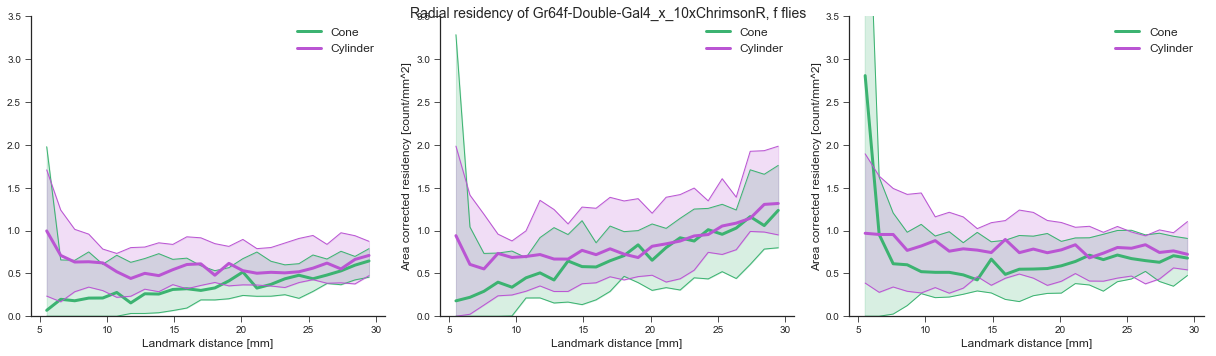

In [215]:
# linear residency around landmarks
radResFig = plt.figure(figsize=(17,5))
radResFig = oneDimResidencyWithVar_2LM_df(radResFig, residency_df, flyIDs, trialName,resdf_keylist.index('dist2cone'),
                                          resdf_keylist.index('dist2cyli'),movementFilter, numBins, histMin, histMax,
                                          1, varStyle, LMcols, LMnames)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

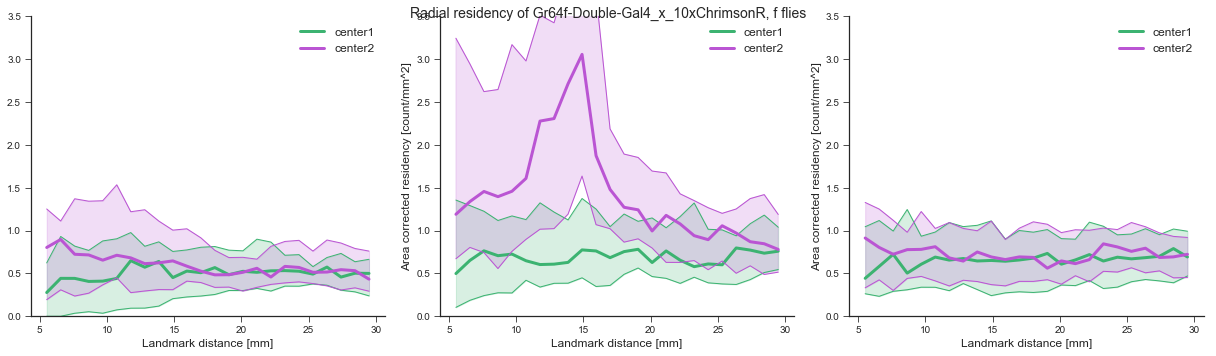

## Distribution of inter-reward intervals and inter-entry intervals

In [217]:
try:
    mkdir(analysisDir + 'interVisitInterval/')
except:
    print('Plot directory already exists')

Plot directory already exists


#### Choose reward center coordinates appropriately 

In [218]:
# if reward around LM:
rewardCenter = LMcoords[1] #LMcoords[0] # 

useShifted = True #True #False #

binRange = (0,10)
numBins = 40

trialtype=trialName[1]  #training

In [219]:
# reward-based analysis
flyRewardStTimeDistr = np.zeros((numFlies,numBins))
allInterEntryTimes = []
numRewards = np.zeros((numFlies))

# visit-based analysis
flyEntryTimeDistr = np.zeros((numFlies,numBins))
allRewardTimes = []
numEntries = np.zeros((numFlies))

for fly in range(numFlies):
    querystring = '(trialtype=="train") & (flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    if useShifted:
        xtrial = xtrial+gridSize/2
        xtrial[xtrial>2*gridSize] = xtrial[xtrial>2*gridSize]-2*gridSize
        ytrial = ytrial-gridSize/2
        ytrial[ytrial<-gridSize] = ytrial[ytrial<-gridSize]+2*gridSize

    # compute distance to closest reward center
    dist2closest = np.minimum( np.hypot((xtrial-rewardCenter[0][0]),(ytrial-rewardCenter[0][1])),
                                   np.hypot((xtrial-rewardCenter[1][0]),(ytrial-rewardCenter[1][1])) )

    entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest,time,visitRad)
    
    evTime = time[np.diff(np.hstack((0,ev)))>0]

    if type(entryTime) is float:
        numEntries[fly] = 0
        flyEntryTimeDistr[fly,:] = np.nan*np.ones(numBins)
    else:
        numEntries[fly] = len(entryTime)
        allInterEntryTimes = np.hstack((allInterEntryTimes,np.diff(entryTime)))
        hist, bin_edges = np.histogram(np.diff(entryTime), bins=numBins, range=binRange, density=True)
        flyEntryTimeDistr[fly,:] = hist
        
    if type(evTime) is float:
        numRewards[fly] = 0
        flyRewardStTimeDistr[fly,:] = np.nan*np.ones(numBins)
    else:
        numRewards[fly] = len(evTime)
        allRewardTimes = np.hstack((allRewardTimes,np.diff(evTime)))
        hist, bin_edges = np.histogram(np.diff(evTime), bins=numBins, range=binRange, density=True)
        flyRewardStTimeDistr[fly,:] = hist

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


29


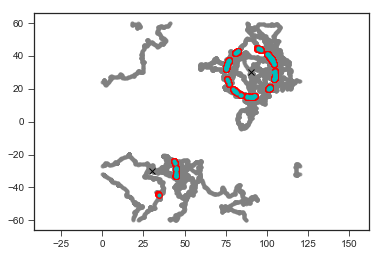

In [220]:
# Check if alignment is correct
plt.plot(xtrial,ytrial,'.',color='grey', alpha=0.6)
plt.plot(xtrial[ev>0],ytrial[ev>0],'ro')
plt.plot(xtrial[entries>0],ytrial[entries>0],'c.')
plt.plot(rewardCenter[0][0],rewardCenter[0][1],'kx')
plt.plot(rewardCenter[1][0],rewardCenter[1][1],'kx')
plt.axis('equal')
print(fly)

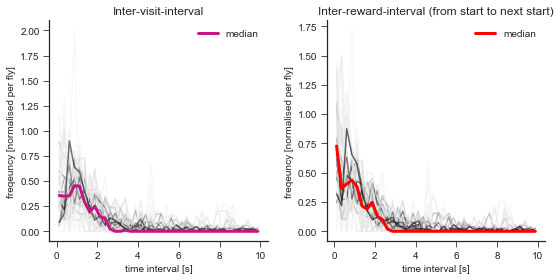

In [221]:
entrydistfig, axs = plt.subplots(1,2, figsize=(8,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2

# generate colormap encoding total number of visits
cNorm  = colors.Normalize(vmin=-10, vmax=max(numEntries))
entryCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Greys')

# plot distribution
for fly in range(numFlies):
    axs[0].plot(binEds,flyEntryTimeDistr[fly,:], 
                    color=entryCMap.to_rgba(numEntries[fly]), alpha=0.6, label='')
    axs[1].plot(binEds,flyRewardStTimeDistr[fly,:], 
                    color=entryCMap.to_rgba(numRewards[fly]), alpha=0.6, label='')
axs[0].plot(binEds,np.nanmedian(flyEntryTimeDistr,axis=0), color='mediumvioletred', linewidth=3, label='median')
axs[0].set_title('Inter-visit-interval')

axs[1].plot(binEds,np.nanmedian(flyRewardStTimeDistr,axis=0), color='red', linewidth=3, label='median')
axs[1].set_title('Inter-reward-interval (from start to next start)')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlabel('time interval [s]')
    ax.set_ylabel('freqeuncy [normalised per fly]')
    ax.legend()
        
entrydistfig.tight_layout()

entrydistfig.savefig(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
           +'_interEventIntervalDistr_singleFly_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

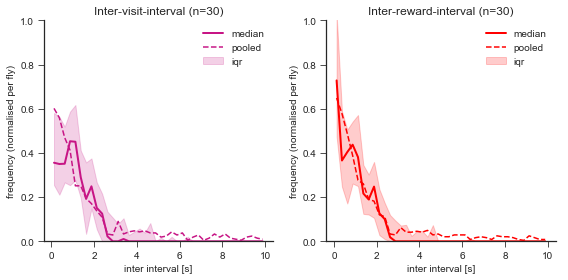

In [222]:
entrydistfig, axs = plt.subplots(1,2,figsize=(8,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2

[qt25, qt50, qt75] = np.nanpercentile(flyEntryTimeDistr[:,:],[25,50,75],axis=0)
axs[0].plot(binEds,qt50, color='mediumvioletred', linewidth=2, label='median')
axs[0].fill_between(binEds,qt25, qt75, color='mediumvioletred', linewidth=1, label='iqr', alpha=0.2)

hist, bin_edges = np.histogram(np.diff(allInterEntryTimes), bins=numBins, range=binRange, density=True)
axs[0].plot(binEds,hist, color='mediumvioletred', linewidth=1.5, linestyle='dashed', label='pooled')

axs[0].set_title('Inter-visit-interval (n='+str(numFlies)+')')
interVisitIntervalDistr = [qt25,qt50,qt75,hist]

[qt25, qt50, qt75] = np.nanpercentile(flyRewardStTimeDistr[:,:],[25,50,75],axis=0)
axs[1].plot(binEds,qt50, color='red', linewidth=2, label='median')
axs[1].fill_between(binEds,qt25, qt75, color='red', linewidth=1, label='iqr', alpha=0.2)

hist, bin_edges = np.histogram(np.diff(allRewardTimes), bins=numBins, range=binRange, density=True)
axs[1].plot(binEds,hist, color='red', linewidth=1.5, linestyle='dashed', label='pooled')

axs[1].set_title('Inter-reward-interval (n='+str(numFlies)+')')
interRewardIntervalDistr = [qt25,qt50,qt75,hist]


for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_ylim(0,1)
    ax.set_xlabel('inter interval [s]')
    ax.set_ylabel('frequency (normalised per fly)')

entrydistfig.tight_layout()

#np.savetxt(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
#           +'_interVisitInterval_percentile25-50-75_train_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
#           +selectionTag+'.csv', interVisitIntervalDistr,delimiter=',')
np.save(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
           +'_interVisitInterval_percentile25-50-75_train_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag, interVisitIntervalDistr)
np.save(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
           +'_interRewardInterval_percentile25-50-75_train_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag, interRewardIntervalDistr)

entrydistfig.savefig(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
           +'_interEventIntervalDistr_medianIQR_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Generate combined plot across groups (need to run analysis for each group first)

In [223]:
summaryDir = sep.join(analysisDir.split(sep)[:-3])+sep
try:
    mkdir(summaryDir + 'summaryPlots/')
except:
    print('Plot directory already exists')

Plot directory already exists


#### Inter-visit-interval

In [224]:
coneIVIDistrName = 'Gr64f-Double-Gal4_x_10xChrimsonR_f_interVisitInterval_percentile25-50-75_train_visitRad15mm_n30.npy'
coneIVIDir = 'cone_20min_15mm'
coneDist = np.load(summaryDir +coneIVIDir+ '/analysis/interVisitInterval'+sep+coneIVIDistrName)

shiftCntrIVIDistrName = 'Gr64f-Double-Gal4_x_10xChrimsonR_f_interVisitInterval_percentile25-50-75_train_visitRad15mm_n30.npy'
shiftCtnrIVIDir = 'control_20min_15mm'
shiftCntrDist = np.load(summaryDir +shiftCtnrIVIDir+ '/analysis/interVisitInterval'+sep+shiftCntrIVIDistrName)

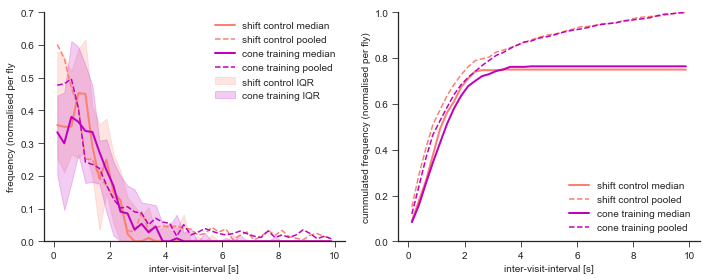

In [225]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

binEds = np.linspace(0,10,41)[1:]-(5./40)

axs[0].plot(binEds,shiftCntrDist[1], color='salmon', linewidth=2, label='shift control median')
axs[0].fill_between(binEds,shiftCntrDist[0], shiftCntrDist[2], color='salmon', linewidth=1, label='shift control IQR', alpha=0.2)
axs[0].plot(binEds,shiftCntrDist[3], color='salmon', linewidth=1.5, linestyle='dashed', label='shift control pooled')

axs[0].plot(binEds,coneDist[1], color='m', linewidth=2, label='cone training median')
axs[0].fill_between(binEds,coneDist[0], coneDist[2], color='m', linewidth=1, label='cone training IQR', alpha=0.2)
axs[0].plot(binEds,coneDist[3], color='m', linewidth=1.5, linestyle='dashed', label='cone training pooled')

axs[1].plot(binEds,np.cumsum(shiftCntrDist[1]*np.diff(bin_edges)), color='salmon', linewidth=2, label='shift control median')
axs[1].plot(binEds,np.cumsum(shiftCntrDist[3]*np.diff(bin_edges)), color='salmon', linewidth=1.5, linestyle='dashed', label='shift control pooled')

axs[1].plot(binEds,np.cumsum(coneDist[1]*np.diff(bin_edges)), color='m', linewidth=2, label='cone training median')
axs[1].plot(binEds,np.cumsum(coneDist[3]*np.diff(bin_edges)), color='m', linewidth=1.5, linestyle='dashed', label='cone training pooled')

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('inter-visit-interval [s]')
axs[0].set_ylim(0,0.7)
axs[1].set_ylim(0,1)
axs[0].set_ylabel('frequency (normalised per fly')
axs[1].set_ylabel('cummulated frequency (normalised per fly)')


fig.tight_layout()
fig.savefig(summaryDir + 'summaryPlots/'+'InterVisitIntervalDistr_train_median-IQR_visitRad'+str(visitRad)+'mm.pdf', format='pdf')

#### Inter-reward-interval

In [226]:
coneIVIDistrName = 'Gr64f-Double-Gal4_x_10xChrimsonR_f_interRewardInterval_percentile25-50-75_train_visitRad15mm_n30.npy'
coneIVIDir = 'cone_20min_15mm'
coneDist = np.load(summaryDir +coneIVIDir+ '/analysis/interVisitInterval'+sep+coneIVIDistrName)

shiftCntrIVIDistrName = 'Gr64f-Double-Gal4_x_10xChrimsonR_f_interRewardInterval_percentile25-50-75_train_visitRad15mm_n30.npy'
shiftCtnrIVIDir = 'control_20min_15mm'
shiftCntrDist = np.load(summaryDir +shiftCtnrIVIDir+ '/analysis/interVisitInterval'+sep+shiftCntrIVIDistrName)

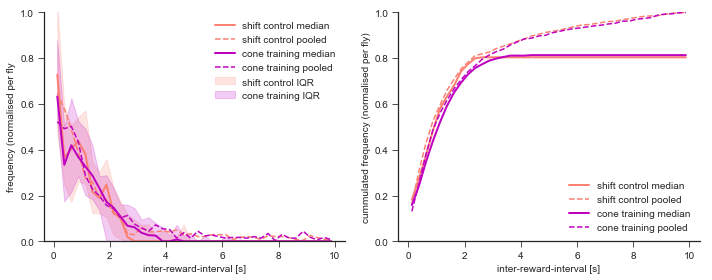

In [227]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

binEds = np.linspace(0,10,41)[1:]-(5./40)

axs[0].plot(binEds,shiftCntrDist[1], color='salmon', linewidth=2, label='shift control median')
axs[0].fill_between(binEds,shiftCntrDist[0], shiftCntrDist[2], color='salmon', linewidth=1, label='shift control IQR', alpha=0.2)
axs[0].plot(binEds,shiftCntrDist[3], color='salmon', linewidth=1.5, linestyle='dashed', label='shift control pooled')

axs[0].plot(binEds,coneDist[1], color='m', linewidth=2, label='cone training median')
axs[0].fill_between(binEds,coneDist[0], coneDist[2], color='m', linewidth=1, label='cone training IQR', alpha=0.2)
axs[0].plot(binEds,coneDist[3], color='m', linewidth=1.5, linestyle='dashed', label='cone training pooled')

axs[1].plot(binEds,np.cumsum(shiftCntrDist[1]*np.diff(bin_edges)), color='salmon', linewidth=2, label='shift control median')
axs[1].plot(binEds,np.cumsum(shiftCntrDist[3]*np.diff(bin_edges)), color='salmon', linewidth=1.5, linestyle='dashed', label='shift control pooled')

axs[1].plot(binEds,np.cumsum(coneDist[1]*np.diff(bin_edges)), color='m', linewidth=2, label='cone training median')
axs[1].plot(binEds,np.cumsum(coneDist[3]*np.diff(bin_edges)), color='m', linewidth=1.5, linestyle='dashed', label='cone training pooled')

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('inter-reward-interval [s]')
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)
axs[0].set_ylabel('frequency (normalised per fly')
axs[1].set_ylabel('cummulated frequency (normalised per fly)')


fig.tight_layout()
fig.savefig(summaryDir + 'summaryPlots/'+'InterRewardIntervalDistr_train_median-IQR_visitRad'+str(visitRad)+'mm.pdf', format='pdf')

## Path shape *after* reinforcement
### Trigger on reinforcement and plot *walking velocities* for following x seconds (or until next reinforcement is delivered)

In [228]:
trialtype =trialName[1]
tmax = 10
tmin = -3
window = int(fps*tmax)
prewindow = int(fps*-tmin)

#fig, ax = plt.subplots(1,1, figsize=(10,7))

triggVT = np.nan*np.ones((numFlies,window+prewindow))
triggVR = np.nan*np.ones((numFlies,window+prewindow))

for fly in range(numFlies):
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
    vt = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
    vr = FOAllFlies_df.query(querystring)['rotVelo'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()
    
    ev[ev>=50] = 100
    ev[ev<50] = 0
    ev = ev/100

    evEnd = np.where(np.diff(ev)<0)[0]
    evSt = np.where(np.diff(ev)>0)[0]

    flyVT = []
    flyVR = []
    for i, es in enumerate(evEnd):
        pathSt = es-prewindow
        if i+1<len(evSt):
            pathEd = min(es+window, evSt[i+1])
        else:
            pathEd = min(es+window, len(time)-1)
        
        vti = vt[pathSt:pathEd]
        vri = abs(vr[pathSt:pathEd])
        timeax = np.linspace(tmin,time[pathEd]-time[es], pathEd-pathSt)
        
        if vti.size == 0:
            continue

        #ax.plot(timeax,vti,'k',alpha=0.1)
        #ax.plot(timeax[-1],vti[-1],'r.')
        flyVT.append(vti)
        flyVR.append(vri)

    for k in range(len(triggVT[0])):
        val = []
        for sl in flyVT:
            if k < len(sl):
                val.append(sl[k])
        triggVT[fly,k] = np.nanmean(np.asarray(val))
        
        val = []
        for sl in flyVR:
            if k < len(sl):
                val.append(sl[k])
        triggVR[fly,k] = np.nanmean(np.asarray(val))
        

#ax.plot(0,0,'ro')
#ax.set_xlim(tmin,tmax)
#ax.set_ylim(-1,1)
#myAxisTheme(ax)


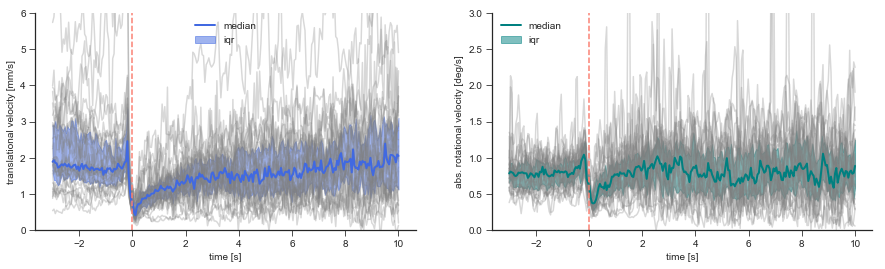

In [229]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

timeax = np.linspace(tmin,tmax, window+prewindow)
for fly in range(numFlies):
    axs[0].plot(timeax,triggVT[fly,:], color='grey',alpha=0.3, label='')
    
[qt25, qt50, qt75] = np.nanpercentile(triggVT,[25,50,75],axis=0)
axs[0].plot(timeax,qt50, color='royalblue', linewidth=2, label='median')
axs[0].fill_between(timeax,qt25, qt75, color='royalblue', linewidth=1, label='iqr', alpha=0.5)

for fly in range(numFlies):
    axs[1].plot(timeax,triggVR[fly,:], color='grey',alpha=0.3, label='')
    
[qt25, qt50, qt75] = np.nanpercentile(triggVR,[25,50,75],axis=0)
axs[1].plot(timeax,qt50, color='teal', linewidth=2, label='median')
axs[1].fill_between(timeax,qt25, qt75, color='teal', linewidth=1, label='iqr', alpha=0.5)

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('time [s]')
    ax.axvline(0,0,1,color='salmon', linestyle='dashed', linewidth=1.5)
axs[0].set_ylim(0,6)
axs[1].set_ylim(0,3)
axs[0].set_ylabel('translational velocity [mm/s]')
axs[1].set_ylabel('abs. rotational velocity [deg/s]')


fig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
    +'_triggeredVelo_medianIQRAcrossFlies_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Trigger on reinforcement and plot *path* for following x seconds (or until next reinforcement is delivered)

## TODO: Fix rotation (need to use position angle rel. to center of closest reward zone)

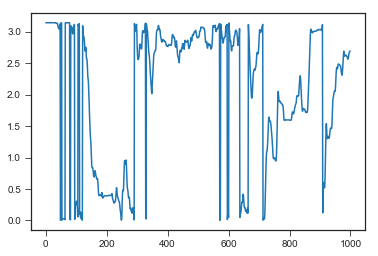

In [450]:
atrial[atrial<0] = atrial[atrial<0]+np.pi
plt.plot(atrial[:1000])

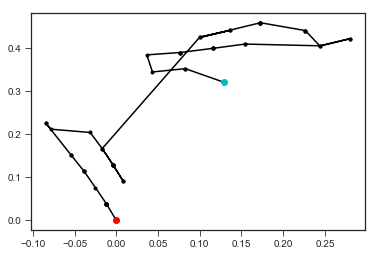

In [500]:
i = 3
window = int(fps*3)

es = evEnd[i]
pathSt = es
pathEd = es+window

xr = xtrial[pathSt:pathEd]-xtrial[pathSt]
yr = ytrial[pathSt:pathEd]-ytrial[pathSt]

rotAng = atrial[pathSt]
x = xr*np.cos(rotAng) - yr*np.sin(rotAng)
y = yr*np.cos(rotAng) + xr*np.sin(rotAng)

plt.plot(x,y,'k.-')
plt.plot(x[0],y[0],'ro')
plt.plot(x[-1],y[-1],'co')

In [499]:
rotAng

2.8925070923275236

(12.622162548856286,
 86.193554164340185,
 -129.73016374307193,
 69.948922083003424)

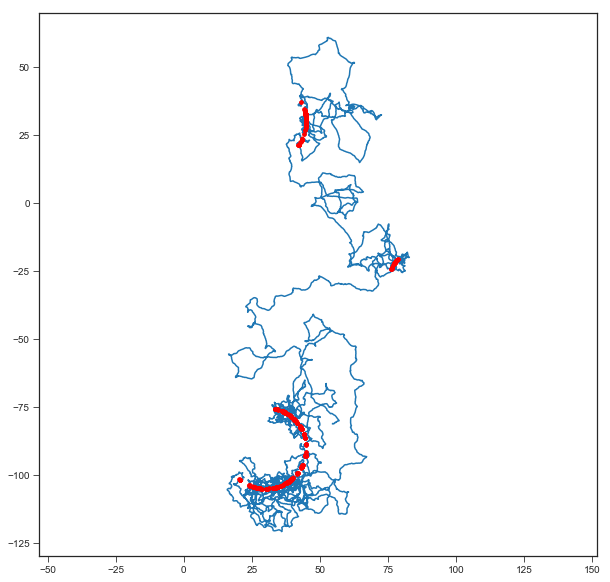

In [482]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(xtrial,ytrial)
plt.plot(xtrial[ev>0],ytrial[ev>0],'r.')
plt.axis('equal')

In [501]:
# if reward around LM:
rewardCenter = LMcoords[1] #LMcoords[0] #

2.87092699319
2.84872640511
2.89250709233
3.03065952633
2.78217700073
3.03509266263
2.67124387347
0.0532499954783
3.00404325524
2.68456073566
2.64017701278
1.24366001454
1.34893181761
1.41549169396
1.61960620466
0.980615176902
0.794264435998
0.417098784642
0.843081295176
0.989512674089
1.54417307438
1.46873994411
1.78377885542
2.63928074305
2.14156911651
0.784744802712
0.536915637791
1.33118007379
0.177499984928
1.50423819577
1.06223703285
0.865269665956
2.01896197212
2.99072639305


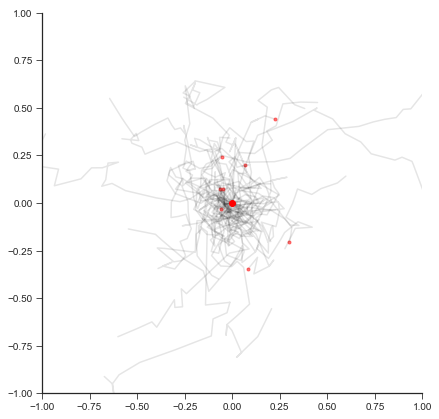

In [472]:
trial = 1
trialtype =trialName[trial]
window = int(fps*2)

fig, ax = plt.subplots(1,1, figsize=(7,7))

for fly in range(1):
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    atrial = FOAllFlies_df.query(querystring)['headingAngle'].values.squeeze()
    atrial[atrial<0] = atrial[atrial<0]+np.pi
    
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    evEnd = np.where(np.diff(ev)<0)[0]
    evSt = np.where(np.diff(ev)>0)[0]+1

    for i, es in enumerate(evEnd):
        pathSt = es
        if i+1<len(evEnd):
            pathEd = min(es+window, evSt[i+1])
        else:
            pathEd = min(es+window, len(evEnd))
        
        x = xtrial[pathSt:pathEd]-xtrial[pathSt]
        y = ytrial[pathSt:pathEd]-ytrial[pathSt]
        
        if x.size == 0:
            continue
        elif x.size < int(fps*2):
            continue
        
        rotAng = atrial[pathSt]
        pathX = x*np.cos(rotAng) - y*np.sin(rotAng)
        pathY = y*np.cos(rotAng) + x*np.sin(rotAng)

        ax.plot(pathX,pathY,'k',alpha=0.1)

        if i+1<len(evEnd):
            if es+window > evEnd[i+1]:
                ax.plot(pathX[-1],pathY[-1],'r.',alpha=0.5)

ax.plot(0,0,'ro')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
myAxisTheme(ax)
ax.set_aspect('equal')

fig.savefig(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
           +'_pathAfterReward_'+str(int(window/fps))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Trigger on reinforcement and plot *absolute distance moved* for following x seconds (or until next reinforcement is delivered)

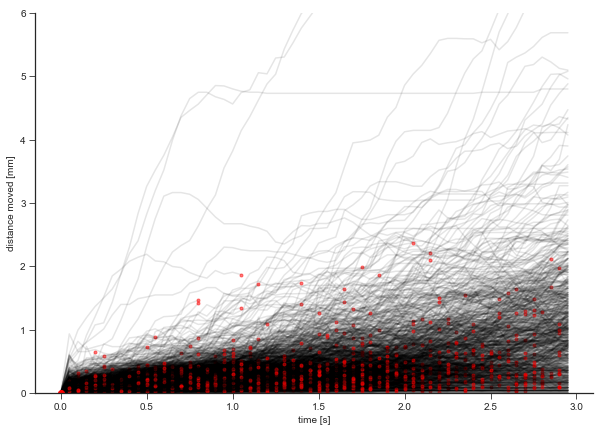

In [440]:
trial = 1
trialtype =trialName[trial]
window = int(fps*3)

fig, ax = plt.subplots(1,1, figsize=(10,7))

for fly in range(numFlies):
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    atrial = FOAllFlies_df.query(querystring)['headingAngle'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    evStart = np.where(np.diff(ev)>0)[0]+1
    
    for i, es in enumerate(evStart):
        pathSt = es
        if i+1<len(evStart):
            pathEd = min(es+window, evStart[i+1])
        else:
            pathEd = min(es+window, len(evStart))

        ast = atrial[pathSt-1]
        if ast<0: ast = 2*np.pi+ast

        pathX = xtrial[pathSt:pathEd]-xtrial[pathSt]
        pathY = ytrial[pathSt:pathEd]-ytrial[pathSt]
        dist = np.hypot(pathX,pathY)
        
        if pathY.size == 0:
            continue

        ax.plot(time[pathSt:pathEd]-time[pathSt],dist,'k',alpha=0.1)

        if i+1<len(evStart):
            if es+window > evStart[i+1]:
                ax.plot(time[pathEd-1]-time[pathSt],dist[-1],'r.',alpha=0.5)


ax.plot(0,0,'ro')
ax.set_ylim(0,6)
ax.set_xlabel('time [s]')
ax.set_ylabel('distance moved [mm]')
myAxisTheme(ax)

fig.savefig(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
           +'_distAfterReward_'+str(int(window/fps))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

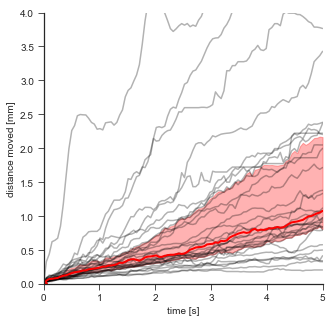

In [441]:
trial = 1
trialtype =trialName[trial]
tmax = 5
window = int(fps*tmax)
timeax = np.linspace(0,tmax, window)

fig, ax = plt.subplots(1,1, figsize=(5,5))

distAll = np.nan*np.ones((numFlies, window))

for fly in range(numFlies):
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    atrial = FOAllFlies_df.query(querystring)['headingAngle'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    evStart = np.where(np.diff(ev)>0)[0]+1

    dist = np.nan*np.ones((len(evStart), window))

    for i, es in enumerate(evStart):

        if (es + window) > len(xtrial):
            continue

        pathX = xtrial[es:es+window]-xtrial[es]
        pathY = ytrial[es:es+window]-ytrial[es]
        dist[i,:] = np.hypot(pathX,pathY)

    ax.plot(timeax,np.nanmedian(dist, axis=0),'k', alpha=0.3)
    distAll[fly,:] = np.nanmedian(dist, axis=0)

[qt25, qt50, qt75] = np.nanpercentile(distAll,[25,50,75],axis=0)

ax.plot(timeax,qt50, color='red', linewidth=2, label='median')
ax.fill_between(timeax,qt25, qt75, color='red', linewidth=1, label='iqr', alpha=0.3)

ax.plot(0,0,'ro')
ax.set_xlim(0,tmax)
ax.set_ylim(0,4)
ax.set_xlabel('time [s]')
ax.set_ylabel('distance moved [mm]')
myAxisTheme(ax)

fig.savefig(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
           +'_distAfterRewardMedianFly_'+str(int(window/fps))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

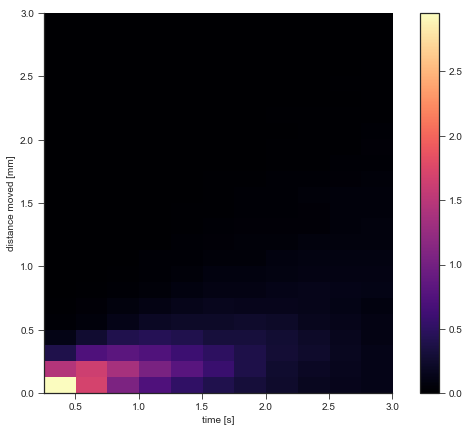

In [442]:
trial = 1
trialtype =trialName[trial]
window = int(fps*3)

querystring = '(trialtype=="' + trialtype + '")'
xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
atrial = FOAllFlies_df.query(querystring)['headingAngle'].values.squeeze()
ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

evStart = np.where(np.diff(ev)>0)[0]+1

timeAll = []
distAll = []

for i, es in enumerate(evStart):
    pathSt = es
    if i+1<len(evStart):
        pathEd = min(es+window, evStart[i+1])
    else:
        pathEd = min(es+window, len(evStart))

    ast = atrial[pathSt-1]
    if ast<0: ast = 2*np.pi+ast

    pathX = xtrial[pathSt:pathEd]-xtrial[pathSt]
    pathY = ytrial[pathSt:pathEd]-ytrial[pathSt]
    dist = np.hypot(pathX,pathY)

    if pathY.size == 0:
        continue
        
    timeAll = np.hstack((timeAll,time[pathSt:pathEd]-time[pathSt]))
    distAll = np.hstack((distAll,dist))
    
fig, ax = plt.subplots(1,1, figsize=(10,7))

xedges = np.linspace(0.25,window/fps,12)
yedges = np.linspace(0,3,25)

H, xedges, yedges = np.histogram2d(timeAll, distAll, bins=(xedges, yedges), normed=True)
H = H.T

hist2d = ax.imshow(H, interpolation='nearest', origin='low',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect=1, cmap='magma')
fig.colorbar(hist2d, ax=ax)

ax.set_xlabel('time [s]')
ax.set_ylabel('distance moved [mm]')
myAxisTheme(ax)

#fig.savefig(analysisDir + 'interVisitInterval/'+ genotype +'_'+flyIDs[0][0]
#           +'_distAfterRewardHist_'+str(int(window/fps))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Quantify "curvyness of path"
### Turtosity of path in sliding window

### Check if some flies had a strong bias in their rotational velocity

In [33]:
rotbias = np.nan*np.ones((numFlies, len(trialName)))
rotamount = np.nan*np.ones((numFlies, len(trialName)))

for fly in range(numFlies):
    for i, trial in enumerate(trialName):
        querystring = '(trialtype=="' + trial + '") & (flyID =="' + flyIDs[fly] +  '") & (moving > 0)'
        perFlyvR = FOAllFlies_df.query(querystring)['rotVelo'].values.squeeze()

        if len(perFlyvR) == 0: continue
        
        rotbias[fly,i] = abs(sum(perFlyvR<0) - sum(perFlyvR>0)) / float(len(perFlyvR))
        rotamount[fly,i] = np.mean(abs(perFlyvR))

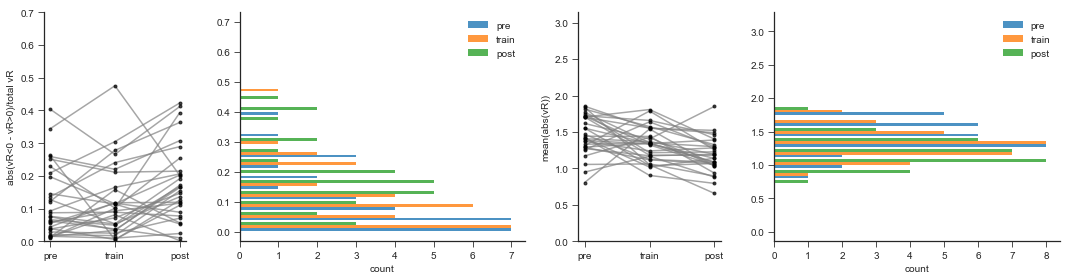

In [34]:
rotBiasfig, axs = plt.subplots(1,4,figsize=(15,4), gridspec_kw={'width_ratios':[1,2,1,2]})

axs[0].plot(rotbias.T, alpha=0.7, color='grey')
axs[0].plot(rotbias.T, '.', alpha=0.7,color='k')
axs[0].set_xticks([0,1,2])
axs[0].set_xticklabels(trialName)
axs[0].set_ylim(0, 0.7)
axs[0].set_ylabel('abs(vR<0 - vR>0)/total vR')

axs[1].hist(rotbias[:,:], range=(0,0.7), bins=20, cumulative=False, histtype='bar',
            align='mid',  orientation='horizontal', alpha=0.8)
axs[1].legend(trialName)
axs[1].set_xlabel('count')

axs[2].plot(rotamount.T, alpha=0.7,color='grey')
axs[2].plot(rotamount.T, '.', alpha=0.7,color='k')
axs[2].set_xticks([0,1,2])
axs[2].set_xticklabels(trialName)
axs[2].set_ylim(0, np.pi)
axs[2].set_ylabel('mean(abs(vR))')

axs[3].hist(rotamount[:,:], range=(0,np.pi), bins=20, cumulative=False, histtype='bar',
            align='mid', orientation='horizontal',  alpha=0.8)
axs[3].legend(trialName)
axs[3].set_xlabel('count')

for ax in axs:
    myAxisTheme(ax)
rotBiasfig.tight_layout()

rotBiasfig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_walingVelocities_rotationalBias_n'+
                 str(numFlies)+selectionTag+'.pdf', format = 'pdf')

In [234]:
# Which flies had an excessive rotational bias throughout the experiment?
maxRotBias = 0.25

highRotBias = np.where(np.sum(rotbias>maxRotBias, axis=1)==3)[0]

print('Out of {} measured flies, {} had a rotational bias above {} in all three trials.\n').format(numFlies,
     len(highRotBias), maxRotBias)
print ('Those flies were: {}'.format([flyIDs[i] for i in highRotBias]))
print ('With indices {}'.format( highRotBias))

Out of 22 measured flies, 0 had a rotational bias above 0.25 in all three trials.

Those flies were: []
With indices []
